In [1]:
using Lux, Optimisers, Random, ForwardDiff, Statistics, Plots, PlotThemes; theme(:dao)

In [2]:
rng = Random.default_rng()

TaskLocalRNG()

In [3]:
nNeurons = 40;
ψmodel = Chain(
    Dense(2 => nNeurons, tanh), #input [x,t]
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => 2, identity), #output [re(ψ), im(ψ)]
)

Chain(
    layer_1 = Dense(2 => 40, tanh_fast),  # 120 parameters
    layer_2 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_3 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_4 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_5 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_6 = Dense(40 => 2),           # 82 parameters
)         # Total: 6_762 parameters,
          #        plus 0 states, summarysize 96 bytes.

In [4]:
ps, st = Lux.setup(rng, ψmodel);

In [5]:
xtest = randn(2);
y, st = Lux.apply(ψmodel, xtest, ps, st)

([-0.17970842144103283, -0.3588226928328492], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [6]:
function vector_hessian(f, x)
    n = length(x)
    out = ForwardDiff.jacobian(x -> ForwardDiff.jacobian(f, x), x)
    return reshape(out, n, n, n)
end

vector_hessian (generic function with 1 method)

In [7]:
# ψNN(x,t) = [x^2 + t, t+exp(x)]

ψNN (generic function with 1 method)

Let $E$ be some units of energy. The dimension-less Schrodinger equation is:
$$
i \frac{\partial \psi}{\partial \tau} = -\frac{1}{2} \frac{\partial^2\psi}{\partial \xi^2} + (V(\beta\xi)/E)\psi
\\
\beta = \frac{\hbar}{\sqrt{m E}}
\\
x = \beta \xi
\\
t = \frac{\hbar}{E} \tau
$$

In [18]:
ForwardDiff.derivative(x -> ψNN(x,1.0),1.0)

2-element Vector{Float64}:
  0.22917679528171722
 -0.14427634485073115

In [29]:
ψNN(x,t) = (Lux.apply(ψmodel, [x,t], ps, st)[1])
∂ψ∂t(ψ,x,t) = ForwardDiff.derivative(t -> ψ(x,t),t) |> X -> complex(X...);
∂²ψ∂x²(ψ,x,t) = ForwardDiff.derivative(x->ForwardDiff.derivative(x->ψ(x,t),x),x) |> X -> complex(X...);
V(x) = 0;
TDSE(ψ,x,t) = 1.0im*∂ψ∂t(ψ,x,t) - (-∂²ψ∂x²(ψ,x,t)/2 + V(x)*complex(ψ(x,t)...));
# DReImψ(ψ,x,t) = ForwardDiff.jacobian(X -> ψ(X...),[x,t]);
# ∂ψ∂t(ψ,x,t) = DReImψ(ψ,x,t)[:,2] |> X -> complex(X...);
# ∂²ψ∂x²(ψ,x,t) = ForwardDiff.derivative(x->DReImψ(ψ,x,t)[:,1],x) |> X -> complex(X...);
# V(x) = 0;
# TDSE(ψ,x,t) = 1.0im*∂ψ∂t(ψ,x,t) - (-∂²ψ∂x²(ψ,x,t)/2 + V(x)*complex(ψ(x,t)...));

TDSE (generic function with 1 method)

In [114]:
using BenchmarkTools
@benchmark TDSE(ψNN,randn(2)...)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  30.016 μs …  26.605 ms  ┊ GC (min … max): 0.00% … 99.64%
 Time  (median):     34.228 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.744 μs ± 265.847 μs  ┊ GC (mean ± σ):  6.67% ±  1.00%

       ▅█▆▁                                                     
  ▁▂▃▅█████▇▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  30 μs           Histogram: frequency by time           63 μs <

 Memory estimate: 27.77 KiB, allocs estimate: 109.

In [113]:
ψtest(x,t) = (collect∘reim)(sin(π*(x-1/2))*exp(-1.0im*π^2*t/2))
abs(TDSE(ψtest,randn(2)...))/eps()


0.0

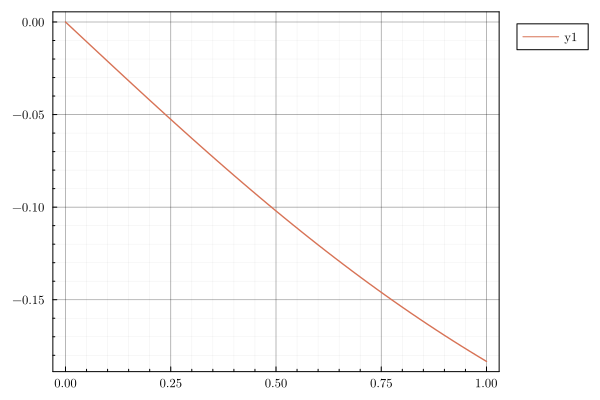

In [10]:
plot(0:0.02:1,imag.((x->complex(ψNN(x,0.0)...)).(0:0.02:1)))

In [16]:
Ncollocation = 2000;
Tmax = 50.0;
collocationPts =hcat(rand(Ncollocation), Tmax*rand(Ncollocation));

mean([abs(TDSE(ψNN,X...)) for X ∈ eachrow(collocationPts)])


0.022069841026647958